<a href="https://colab.research.google.com/github/annkristinbalve/Process-centric-gp_tutorial/blob/main/Tutorial_Colab_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Process-Centric Gaussian Processes - Interactive Tutorial
#### Ann-Kristin Balve
##### Supervisor: Professor Carl Edward Rasmussen
##### Department of Engineering, University of Cambridge


## Instruction:

When running this notebook on Colab, you can connect to the T4 GPU which will speed up the interactions.

Please run the notebook cell by cell to ensure that all plots display properly.

## Introduction

This tutorial introduces a new, conceptually easier framework for Gaussian Processes (GPs) - the 'process-centric' view - which helps developing an intuition of what GPs are.  According to this view, a GP is an object that is specified by a mean and covariance function and allows only two main operations: conditioning and operation. You will understand at the end of this tutorial exactly what this means.

<div class="alert alert-block alert-danger"><b>Note:</b> We will use <em>plotly</em>, <em>nbconvert</em>, and <em>ipywidgets</em> to create an interactive tutorial. To make sure that the notebook runs without errors, make sure that you have the correct package versions installed (as specified in <em>requirements.py</em>). If you use Google Colab, make sure to run the following code block.
</div>

In [ ]:
## Uncomment the following to clone all necessary modules from Github and install the correct package versions.
!pip install plotly==5.10
!pip install ipywidgets==8.1.3

!rm -rf Process-centric-gp_tutorial
!git clone https://github.com/annkristinbalve/Process-centric-gp_tutorial.git
%cd Process-centric-gp_tutorial

from google.colab import output as g_colab_output
g_colab_output.enable_custom_widget_manager()

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.2/15.2 MB 38.2 MB/s eta 0:00:00
  Attempting uninstall: plotly
    Found existing installation: plotly 5.15.0
    Uninstalling plotly-5.15.0:
      Successfully uninstalled plotly-5.15.0
  Using cached jedi-0.19.1-py2.py3-none-any.whl.metadata (22 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.4/139.4 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 62.7 MB/s eta 0:00:00
Using cached jedi-0.19.1-py2.py3-none-any.whl (1.6 MB)
  Attempting uninstall: widgetsnbextension
    Found existing installation: widgetsnbextension 3.6.8
    Uninstalling widgetsnbextension-3.6.8:
      Successfully uninstalled widgetsnbextension-3.6.8
  Attempting uninstall: ipywidgets
    Found existing installation: ipywidgets 7.7.1
    Uninstalling ipywidgets-7.7.1:
      Successfully uninstalled ipywidgets-7.7.1
Cloning into 'Process-centric-gp_tutorial'...
remote: Enumerating objects: 108, done.
remote: Counting objects: 100% (108

In [ ]:
## Importing all necessary packages
import numpy as np
import autograd.numpy as anp
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
from scipy.stats import multivariate_normal, norm
from scipy.spatial.distance import cdist
import math
import ipywidgets as widgets
from ipywidgets import interactive, HBox, VBox, Layout
from IPython.display import display
import plotly.graph_objects as go
from plotly.subplots import make_subplots

## Bivariate Gaussian Distribution

Gaussian Processes rely on multivariate Gaussian distributions and it's properties.

<div class="alert alert-block alert-success">A <b>Gaussian Distribution </b> is a continuous probability distribution for a real-valued random variable, fully specified by a mean and covariance. It is given by:

$
p(\mathbf{x} | \boldsymbol{\mu}, \boldsymbol{\Sigma}) = \mathcal{N}(\mathbf{x} | \boldsymbol{\mu}, \boldsymbol{\Sigma}) = \frac{1}{(2\pi)^{D/2}|\boldsymbol{\Sigma}|^{1/2}} \exp\left(-\frac{1}{2} (\mathbf{x} - \boldsymbol{\mu})^\top \boldsymbol{\Sigma}^{-1} (\mathbf{x} - \boldsymbol{\mu})\right)
$

</div>

In the following plot, we will explore a 3D plot of a the bivariate Gaussian distribution, which is a Gaussian distribution for two jointly random variables. The bivariate Gaussian is specified by a 2 x 1 mean vector $\mu$ and a 2 x 2 covariance matrix $\Sigma$.


In [ ]:
from visualisations import plot_multivariate_Gaussian_3d, is_positive_semi_definite_2x2
## adjust mean and cov to change the mean vector and covariance matrix
mean = [0, 0]
cov_xy = 0.9
cov = np.array([[1, cov_xy], [cov_xy, 1]])

if is_positive_semi_definite_2x2(cov):
    plot_multivariate_Gaussian_3d(mean, cov)
else:
    print("The covariance matrix is not positive semi-definite. Please specify a positive semi-definite matrix.")

<div class="alert alert-block alert-info"><b>3D Bivariate Gaussian Plot:</b> The plot shows the probability density for a bivariate Gaussian. The marginal distributions for x1 and x2 are shown in green and black respectively. Samples drawn from this multivariate distribution are shown as brown dots. The plot can be rendered through mouse interaction.
</div>

Before we move to Gaussian processes, we will explore the two main properties of Gaussian processes - closure under marginalisation and closure under conditioning.

### Property I of Gaussians: The Marginalisation Property

The marginalisation property ensures that we obtain a finite dimensional object which we can visualise and use to make predictions. In the example of a bivariate Gaussian, we can obtain the parameters of the marginal distribution of $x_1$ by simply ignoring contributions of the random variable $x_2$ that we are not interested in. Marginalisation of a Gaussian results in another Gaussian, thus the distribution is closed.

$$
\begin{bmatrix}
x_1 \\
x_2
\end{bmatrix} \sim \mathcal{N}\left(\begin{bmatrix}
m_1 \\
m_2
\end{bmatrix}, \begin{bmatrix}
\sigma_1^2 & c \\
c & \sigma_2^2
\end{bmatrix}\right) \implies x_1 \sim \mathcal{N}(m_1, \sigma_1^2).
$$




In [ ]:
from visualisations import plot_multivariate_Gaussian_2d

def update(mean_x, mean_y, cov_xy):
    mean = [mean_x, mean_y]
    cov = np.array([[1, cov_xy], [cov_xy, 1]])
    if is_positive_semi_definite_2x2(cov):
        plot_multivariate_Gaussian_2d(mean, cov)
    else:
        print("The covariance matrix is not positive semi-definite. Please specify a positive semi-definite matrix.")

mean_x_slider = widgets.FloatSlider(value=0, min=-3, max=3, step=0.5, description='Mean (m1)')
mean_y_slider = widgets.FloatSlider(value=0, min=-3, max=3, step=0.5, description='Mean (m2)')
cov_xy_slider = widgets.FloatSlider(value=0, min=0, max=0.9, step=0.2, description='Cov(x1x2) = c')

interactive_plot = interactive(update, mean_x=mean_x_slider, mean_y=mean_y_slider, cov_xy=cov_xy_slider)
interactive_plot

interactive(children=(FloatSlider(value=0.0, description='Mean (m1)', max=3.0, min=-3.0, step=0.5), FloatSlide…

<div class="alert alert-block alert-info"><b>Marginal Distributions:</b> The plot shows the marginals $p(x1)$ (green) and $p(x2)$ (black). The mean values of each distribution ($m1$ and $m2$) as well as the correlation value $c$ can be adjusted via sliders. The mean $\mu$ is represented by a dark-blue circle. The direction of the magenta/cyan lines corresponds to the eigenvectors of the covariance matrix, whereas their length gives the spread of the distribution in that direction, calculated as a muliple of the square roots of the eigenvalues.

  We can see that the marginal distributions are independent from the correlation $c$. However, the shape of the joint distribution changes with $c$ which can be seen by the adjusted eigenvectors.

### Property II of Gaussians: Conditioning Property
While the marginal distribution is a lower-dimensional distribution obtained by ignoring information, conditioning incorporates new knowledge about the value of one variable. This results in another lower-dimensional Gaussian distribution, thus the Gaussian distribution is closed under conditioning. For a bivariate Gaussian we use:

$$
p(x_1 | x_2) = \mathcal{N} \left( m_1 + c\sigma_2^{-2} (x_2 - m_2), \sigma_1^2 - c\sigma_2^{-2}c^\top \right).
$$

The next visualisation allows to explore the conditioning operation and specifically how the conditional Gaussian changes with the correlation value $c$.

In [ ]:


def update(x2_value, cov_xy):
    mean = [0, 0]
    cov = np.array([[1, cov_xy], [cov_xy, 1]])
    plot_multivariate_Gaussian_2d(mean, cov, x2_value)

x2_slider = widgets.FloatSlider(value=0.5, min=-2, max=2, step=0.5, description='X2 value')
cov_xy_slider = widgets.FloatSlider(value=0.5, min=0, max=0.9, step=0.25, description='Cov(x1x2) = c')

interactive_plot = interactive(update, x2_value=x2_slider, cov_xy=cov_xy_slider)
interactive_plot

interactive(children=(FloatSlider(value=0.5, description='X2 value', max=2.0, min=-2.0, step=0.5), FloatSlider…

<div class="alert alert-block alert-info"><b>Conditional Distributions:</b> The two sliders allow to change the x2 value that the random variable x1 is conditioned on as well as the correlation $c$.
</div>

We can see that increasing $c$ reduces the uncertainty which is shown by a smaller conditional variance. This also follows from the above formula. Changing the value of $x_2$ results in a shift of the distribution.

As we have now covered the basics of Gaussian distributions, we can move to Gaussian Processes which are an extension of Gaussian distributions in infinitely many dimensions. What this specifically means is discussed in the following section.

## Process-Centric Gaussian Processes

Gaussian Processes are a special type of stochastic process, where every finite collection of its random variables has a multivariate Gaussian distribution.

<div class="alert alert-block alert-success">
    <b>Stochastic Process:</b> A collection of random variables {𝑋(𝑡):𝑡∈𝑇} indexed by parameter t, used to model systems that occur in a random manner.
</div>

To combine both prior assumptions and data, we can use Bayes' rule. Instead of focusing on the posterior, we will however write Bayes' rule as the joint distribution which has the neat interpretation that we can place all knowns on the left hand side (prior GP and likelihood) and all unknowns on the right hand side (posterior GP and marginal likelihood). The prior GP is specificed by a prior mean and covariance function and the likelihood describes how probable the data is given certain function values. On the other side we get another GP, specified by the posterior mean function and covariance function. Along with the posterior, we get the marginal likelihood that indicates how good the model fits the data under the prior.

This yields the following expression:

<div style="text-align: center;">
<img src="https://github.com/annkristinbalve/Process-centric-gp_tutorial/blob/main/Images/main_gpr_regression.drawio.png?raw=1" width="500"/>
</div>


In practical terms, the main difference is that we now return a function of the posterior predictive distribution which is specified by a posterior mean and covariance matrix. In that sense, this new view allows us to condition the posterior GP on new data points as we go along which is also called 'online-updating' and will be discussed later. Furthermore, we can use marginalization to evaluate the Gaussian Process at any test point.

<div class="alert alert-block alert-success">
    <b>According to the process-centric view on GPs</b> a GP is an object specified by a mean and covariance function and allows two main operations: marginalisation and conditioning.
</div>

In mathematical terms, the difference is that we now obtain a posterior which is a stochastic process, whereas previous views focused on the posterior predictive distribution as a multivariate Gaussian distribution evaluated at a finite number of test points. Most importantly, stochastic processes are infinite-dimensional objects, specified by functions, whereas probability distributions are finite-dimensional objects, specified by vectors/matrices.

The new view has a much nicer interpretation as both prior and posterior are the now the same type of object. Now, we will explain how to specify a prior GP by defining a mean function and covariance function.

### Prior Gaussian Process
Now, we can look at different covariance and mean functions. For better visualisation, we draw samples from a marginalized GP Prior using the following algorithm:


<div style="text-align: center;">
<img src="https://github.com/annkristinbalve/Process-centric-gp_tutorial/blob/main/Images/draw_sample.drawio.png?raw=1" width="350"/>
</div>

#### Prior Mean Functions

The mean function $m(x)$ specifies the average behavior of the Gaussian process. For a stochastic process, the mean function is given by:

$$
m(x) = \mathbb{E}[f(x)]
$$

The default and most commonly used mean function is the zero mean function implying that the data has zero mean. However, if we assume underlying data trends, we can incorporate that knowledge into our model by specifying a non-zero mean function. A choice of mean functions can be found in the _means.py_ file, including:

| **Mean Function** | **Formula**                          | **Description**                                       |
|-------------------|--------------------------------------|-------------------------------------------------------|
| Zero Mean         |  $$m(x) = 0       $$               | A zero mean function implies that the data has zero mean. |
| Linear Mean       |$$  m(x) = x        $$               | Models linear data trends.                            |
| Periodic Mean     |  $$m(x) = sin(x)      $$           | Can model periodic patterns.                          |
| Step Mean         | $$ m(x) = $\mathbb{1}(x > 0)$$     | Models step changes.                                  |


In the following, we draw ten samples using these four mean functions.

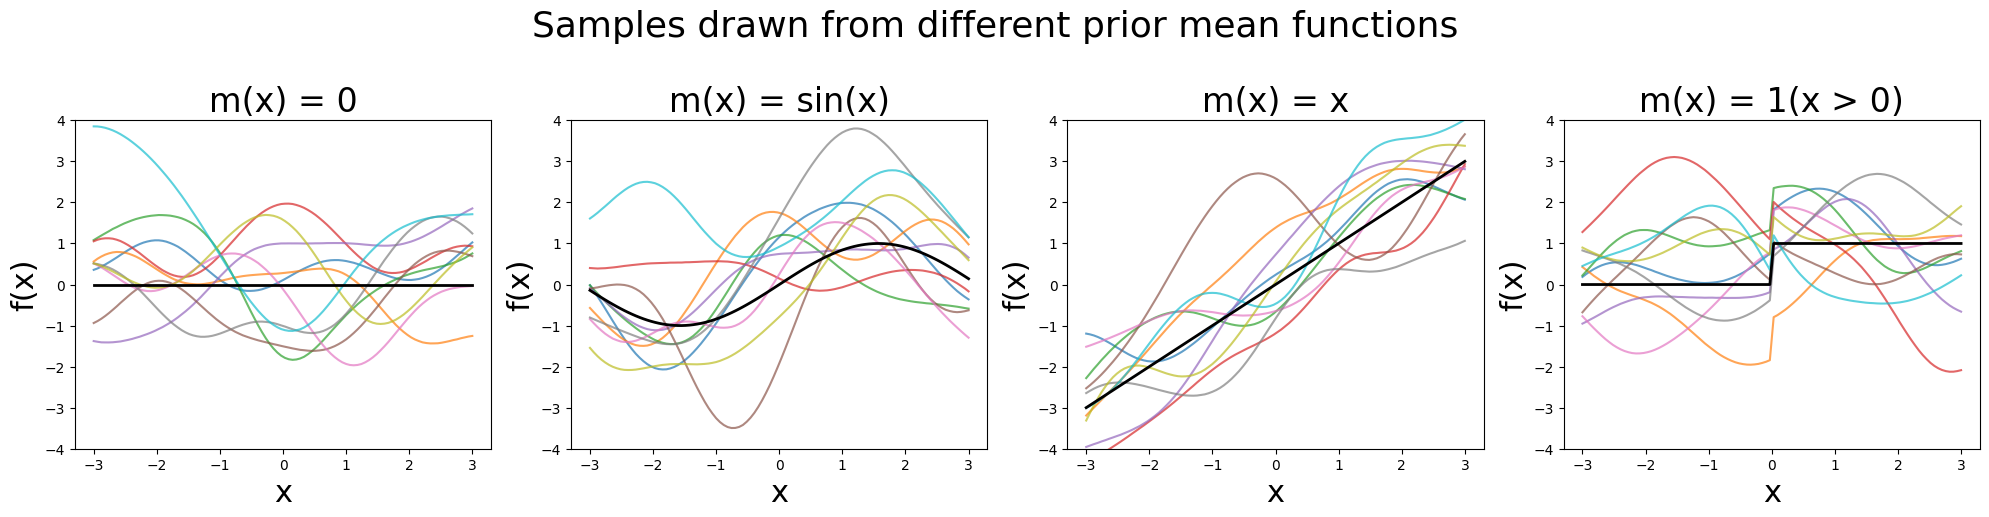

In [ ]:
from means import zero_mean, sine_mean,lin_mean, step_mean ## importing mean functions
from kernels import rbf_kernel, lin_kernel, white_kernel, periodic_kernel ## import covariance functions
from visualisations import plot_prior_samples

params = {'varSigma': 1, 'lengthscale': 1, 'noise': 0.001, 'period': np.pi} ## define kernel parameters
mean_functions = [zero_mean, sine_mean, lin_mean, step_mean] ## define mean functions we want to investigate
mean_names = ['0', 'sin(x)', 'x', '1(x > 0)']
plot_prior_samples(mean_functions, mean_names, params, prior_type = "mean", kernel_f = rbf_kernel)

### Prior Covariance function

The Covariance Function describes in probability theory the change of random variables with varying spatial separation. For a stochastic process, the covariance function is given by

$$
k(x,x') = E[(Y(x) - \mu(x))(Y(x)-\mu(x))]
$$

For Gaussian Processes, the covariance function has to be symmetric and positive semi-definite to be valid. The most common covariance function is the RBF (Radial Basis Function) kernel, which models smooth functions but there are many kernel choices with four examples that can be found in the *kernels.py* file which are:

| Kernel Type    | Formula                                                                                             | Description                                                                                         |
|----------------|-----------------------------------------------------------------------------------------------------|-----------------------------------------------------------------------------------------------------|
| RBF Kernel     | $$ k_{SE}(x,x') = \sigma_{s}^2 \exp\left(\frac{(x-x')^2}{2l^2}\right)  $$ | Radial Basis Function, known as Gaussian kernel which models smooth function behaviour.                                                |
| Periodic Kernel| $$ k_{Per}(x,x') = \sigma_{s}^2 \exp\left(\frac{2 \sin^2(\pi|x-x'|)/p}{l^2}\right)  $$ | Models functions which repeat themselves with periodicity being defined by the additional period parameter $p$                                                          |
| Linear Kernel  | $$ k_{Lin}(x,x') = \sigma_{s}^2 x \cdot x' $$                                                       | Performs Bayesian linear regression, computed as the dot product.                                   |
| White Kernel   | $$ k(x,x') = \sigma_{s}^2 I_{n} $$                                                                  | Models noise only without correlations.                                                                          |

Covariance functions are specified by their hyperparameters. The two most important hyperparameters are:
- the characteristic lengthscale $l$
- the signal variance $\sigma_{s}^2$

When assuming noisy observations, we can also incorporate the the noise variance $\sigma_{n}$.
$$
k_{y}(x,x') = k(x,x') + \sigma_{n}^2 \delta(x,x')
$$


See [The Kernel Cookbook](https://www.cs.toronto.edu/~duvenaud/cookbook/) for more examples of kernels.


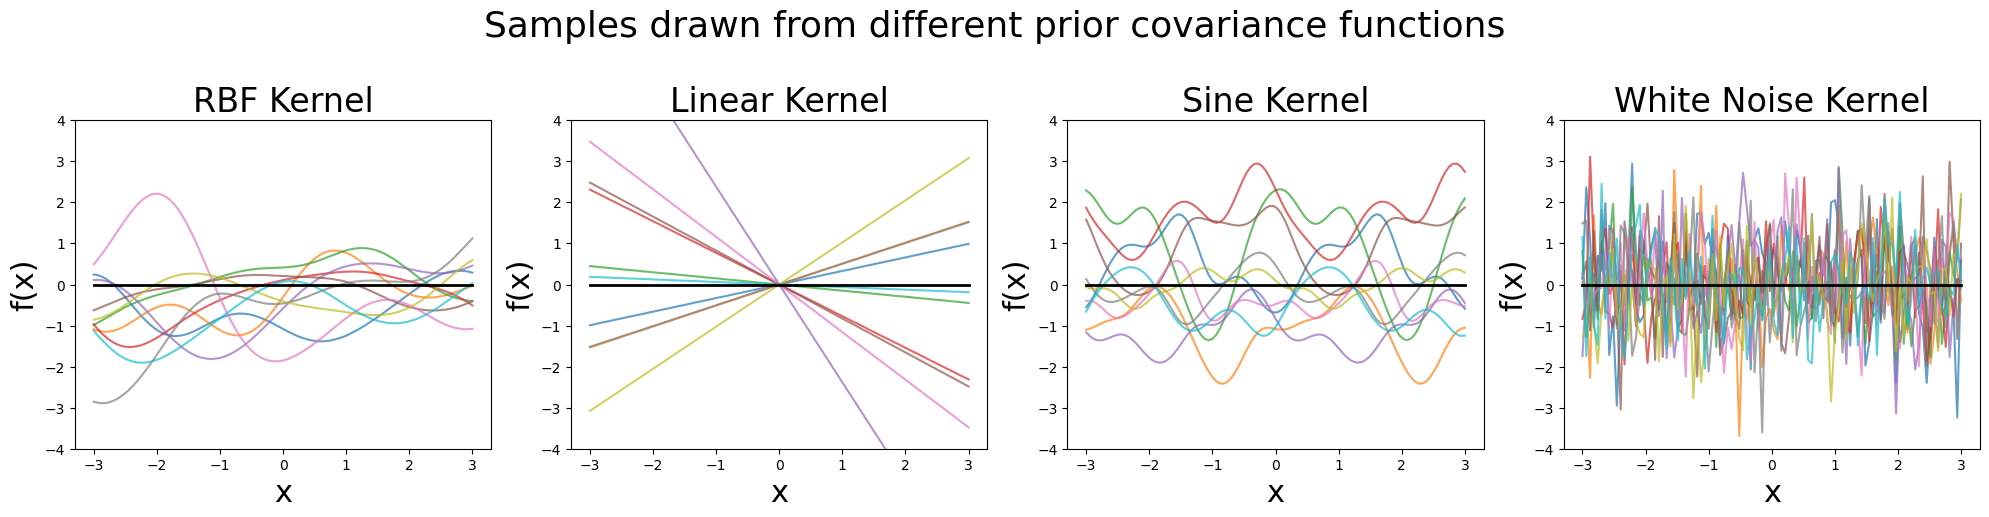

In [ ]:
kernel_functions = [rbf_kernel, lin_kernel, periodic_kernel, white_kernel] ## define kernel functions
kernel_names = ['RBF', 'Linear', 'Sine', 'White Noise']
params = {'varSigma': 1, 'lengthscale': 1, 'noise': 0.001, 'period': np.pi} ## define kernel parameters
mean_names = ['0', 'sin(x)', 'x', '1(x > 0)']
plot_prior_samples(kernel_functions, kernel_names, params, prior_type = "covariance", mean_f = zero_mean)

### Specifying a prior GP
When you specify a prior covariance function, you also have to select appropriate hyperparameters which change the behaviour of the covariance function and thereby the shape of sample functions drawn from the prior GP. In the following visualisation, you can explore the effect of specifying different covariance functions along with their hyperparameters. You can also select different mean functions which change the function trend. Note that we focus on the hyperparameters of the covariance function due to the unpopularity of defining a non-zero mean function.

In [ ]:
from means import mean_dict
from kernels import kernel_dict
from gp_functions import draw_samples
from widgets_helper import varSigma_slider, lengthscale_slider, period_slider, toggle_sliders, noise_slider, create_mean_dropdown, create_cov_dropdown
from visualisations import plot_samples_and_kernels
mean_f = zero_mean

def update_1(mean_name, kernel_name, varSigma, lengthscale, noise, period):
    params = {'varSigma': varSigma, 'lengthscale': lengthscale, 'noise': noise, 'period': period}
    n_samples = 10
    kernel_f = kernel_dict[kernel_name]
    mean_f = mean_dict[mean_name]
    plot_samples_and_kernels(mean_f, kernel_f, params, 10, k_name=kernel_name)

varSigma_slider.description = 'Signal σₛ'
lengthscale_slider.description = 'Lengthscale ℓ'
noise_slider.description = 'Noise σₙ'
period_slider.description = 'Period p'

mean_dropdown_ = create_mean_dropdown()
kernel_dropdown_ = create_cov_dropdown()
controls = HBox([VBox([HBox([kernel_dropdown_]), HBox([varSigma_slider, lengthscale_slider]), HBox([noise_slider, period_slider])]),mean_dropdown_],layout=Layout(align_items='center'))
kernel_dropdown_.observe(toggle_sliders, names='value')
toggle_sliders({'new': kernel_dropdown_.value})
interactive_plot = interactive(update_1, mean_name = mean_dropdown_ ,kernel_name=kernel_dropdown_, varSigma=varSigma_slider,
                               lengthscale=lengthscale_slider, noise=noise_slider, period=period_slider)
display(VBox([controls, interactive_plot.children[-1]]))

<div class="alert alert-block alert-info"><b>Definining a Prior Gaussian Process:</b> We can change the Prior Gaussian Process mean and covariance function using the dropdown menus. For the covariance function, we can also specify the kernel hyperparameters. The left plot shows different samples drawn from the prior GP, the right plot depicts the covariance matrix.

From the interactive plots we can observe that:
* The lengthscale $\ell$ controls the x-axis scaling. Increasing it leads to smoother functions as more neighboring points are considered. When the lengthscale parameter approaches zero, we basically obtain a white noise kernel as no correlations between data are modelled.
* The signal variance $\sigma_s$ controls the y-axis amplitude. Increasing this hyperparameter increases the overall variance magnitude.
* The noise variance $\sigma_n$ controls how noisy the functions are. High noise variance makes the functions more cluttered.
* The period hyperparameter $p$ changes the periodicity for the periodic kernel.

These hyperparameters will be important for fitting a GP to actual data as they change which function are likely given the data. Instead of manually selecting hyperparameters, hyperparameter optimisation can be used to find the best hyperparameter values for a given dataset. This will be discussed later in teh notebook.

## GP Operations: Marginalisation and conditioning

Now, as we discussed how to specify a GP prior, we will turn towards the main two GP operations: marginalisation and conditioning. Since Gaussian Processses are a stochastic process where every pair of random variables follows a multivariate Gaussian distribution, the two properties of Gaussian distributions, closure under marginalisation and closure under conditioning also apply here. First, we will look at the conditioning operation.

### Conditioning

Conditioning a GP means updating a GP with new data. Given new data points, we can move from a prior GP that reflects our prior knowledge to a posterior GP that represents the information from the incoming data.

The conditioning operation adjusts the set of likely functions based on observed data. In practise this means that the GP takes a prior mean and covariance function and data and returns the posterior mean and covariance function and the log marginal likelihood which we will be discussed later. The precise algorithmic implementation can be found here:  

<div style="text-align: center;">
<img src="https://github.com/annkristinbalve/Process-centric-gp_tutorial/blob/main/Images/pseudo_code_conditioning.drawio.png?raw=1" width="500"/>
</div>


When this updating happens sequentially, this is called Bayesian online updating. This means that posterior mean and covariance functions are used as a new prior in the following batch update. This can be explored in the following plot.


In [ ]:
from visualisations import conditional_gps_visualisation
from data import data_1d, f, data_1d_evenly_spaced
from gp_functions import GP_conditional, GP_marginal
from widgets_helper import batch_size_dropdown, create_status_label


np.random.seed(42) # random seed for reproducibility
N = 8  # number of training points -> note that increasing training data points will significantly increase the running time for the interactive visualisation
n = 200  # number of test points
noise = 0.001  # noise levels of data

X, y = data_1d(N, noise)
Xtest = np.linspace(-5, 5, n).reshape(-1, 1) # number of test points
ytest = f(Xtest) # ground truth
params = {'varSigma': 1, 'lengthscale': 1, 'noise': 0.001, 'period': np.pi} # defining hyperparameters for kernel


# Define the update function
def update(batch_size, mean_f, cov_f):
    kernel_f = kernel_dict[cov_f]
    mean_f = mean_dict[mean_f]
    conditional_gps_visualisation(batch_size, N, X, y, Xtest, ytest, status_label, mean_f, kernel_f, params)


# Setup the controls and display
mean_dropdown2 = create_mean_dropdown()
kernel_dropdown2 = create_cov_dropdown()
status_label = create_status_label()

controls = VBox([HBox([kernel_dropdown2, mean_dropdown2, batch_size_dropdown])])
interactive_plot = interactive(update, batch_size=batch_size_dropdown, mean_f=mean_dropdown2, cov_f=kernel_dropdown2)
display(VBox([controls, interactive_plot.children[-1]]))


<div class="alert alert-block alert-info"><b>Conditioning a GP:</b> You can condition the Gaussian Process on new data points by moving the slider from the left to the right. Each step corresponds to the updating of the GP with one batch of data. You can also change the kernel function and mean function. The batch size indicates with how many data points at once the GP is updated.
</div>

We can observe from the plot that conditioning the GP on the whole data set at once is equivalent to sequentially updating the GP with data batches. Furthermore, we can see that observing more data reduces our uncertainty around the observations.

### Marginalisation

Conditioning a Gaussian Process (GP) results in a posterior GP, which is still an infinite-dimensional object. To visualize our GP and make predictions, we need to perform another step: marginalisation. When marginalising a GP, contributions of the marginalised variables are integrated out. This process effectively reduces the GP from an infinite-dimensional object to a finite-dimensional one. The marginalisation property is particularly useful here, as it allows us to ignore variables irrelevant to our computation. This can be expressed as:

<div style="text-align: center;">
<img src="https://github.com/annkristinbalve/Process-centric-gp_tutorial/blob/main/Images/pseudo_code_marginalisation.drawio.png?raw=1" width="500"/>
</div>

What we obtain in the end is now a vector and a matrix that can be visualized. To understand exactly what happens during marginalisation, let's revisit the GP mathematics. By marginalising the posterior covariance function at some test locations, the posterior covariance matrix is obtained. Let us assume a single test point $\mathbf{x}_*$, then we can obtain the marginalized posterior variance by computing the difference between the two terms:

 - The term $k(\mathbf{x}_*, \mathbf{x}_*)$ represents the variance of the output at the test point $\mathbf{x}_*$ under the prior covariance function.
- The term $k(\mathbf{x}_*, \mathbf{x})[\mathbf{K} + \sigma_n^2 \mathbf{I}]^{-1} k(\mathbf{x}, \mathbf{x}_*)$ quantifies the contribution of the training data to the variance at the test point $\mathbf{x}_*$.

By subtracting the data-dependent term from the prior covariance, the marginalized posterior variance $k_{\vert \mathbf{y}}(\mathbf{x}_*, \mathbf{x}_*)$ is obtained, reflecting to what extent the uncertainty decreases after observing data. A greater similarity between both terms corresponds to more confident predictions.

We can similarly obtain the marginalized posterior mean $\mathbf{m}_{\vert \mathbf{y}}(\mathbf{x}_*)$ by decomposing it into the sum of two terms:

- The prior mean $m(\mathbf{x}_*)$ reflects the expected function value at the test point $\mathbf{x}_*$ under the prior mean function.
- The data contribution term $k(\mathbf{x}_*, \mathbf{x})[\mathbf{K} + \sigma_n^2 \mathbf{I}]^{-1}(\mathbf{y} - \mathbf{m})$ describes to what extent the data explains the average function value.

Note, that the same decomposition holds for several inputs $\mathbf{X}_*$ in which case the marginalized posterior consists of a mean vector and covariance matrix. The following visualisation shows the decomposition of mean and covariance at different input points.


In [ ]:
from visualisations import gpr_components_visualisation
import ipywidgets as widgets
from IPython.display import display

status_label2 = create_status_label()

def update(mean_name, kernel_name):
    status_label2.value = "Updating plot..."

    kernel_f = kernel_dict[kernel_name]
    mean_f = mean_dict[mean_name]
    Xtest = np.linspace(-8, 8, 200).reshape(-1, 1)
    mu_f, k_f, _, cov_contribution_f, mean_contribution_f = GP_conditional(mean_f, kernel_f, params, X, y, True)
    mu_pred, k2 = GP_marginal(mu_f, k_f, Xtest)
    k_pred = np.sqrt(np.diag(k2))

    prior_cov = kernel_f(Xtest, Xtest, params)
    data_cov = cov_contribution_f(Xtest, Xtest)
    posterior_cov = k_f(Xtest, Xtest, params)
    vmin_cov, vmax_cov = min(prior_cov.min(), data_cov.min(), posterior_cov.min()), max(prior_cov.max(), data_cov.max(), posterior_cov.max())

    prior_mean = mean_f(Xtest).reshape(1,-1)
    data_mean = mean_contribution_f(Xtest).reshape(1,-1)
    posterior_mean = mu_f(Xtest).reshape(1,-1)
    vmin_mean, vmax_mean = min(prior_mean.min(), data_mean.min(), posterior_mean.min()), max(prior_mean.max(), data_mean.max(), posterior_mean.max())

    # Update GPR plot
    fig.data[0].x, fig.data[0].y = X.flatten(), y
    fig.data[1].x, fig.data[1].y = Xtest.flatten(), mu_pred
    fig.data[2].x = np.concatenate([Xtest.flatten(), Xtest.flatten()[::-1]])
    fig.data[2].y = np.concatenate([mu_pred - 1.96 * k_pred, (mu_pred + 1.96 * k_pred)[::-1]])

    # Update Heatmaps
    x_vals = Xtest.flatten()
    fig.data[3].z, fig.data[3].x, fig.data[3].y = prior_cov, x_vals, x_vals
    fig.data[4].z, fig.data[4].x, fig.data[4].y = data_cov, x_vals, x_vals
    fig.data[5].z, fig.data[5].x, fig.data[5].y = posterior_cov, x_vals, x_vals
    fig.data[6].z, fig.data[6].x = prior_mean, x_vals
    fig.data[7].z, fig.data[7].x = data_mean, x_vals
    fig.data[8].z, fig.data[8].x = posterior_mean, x_vals
    fig.show()

# Initializing components
fig = gpr_components_visualisation()
mean_dropdown5 = create_mean_dropdown()
kernel_dropdown5 = create_cov_dropdown()

# Creating layout
controls = VBox([HBox([kernel_dropdown5, mean_dropdown5], layout=widgets.Layout(margin='10px 0px'))])

# Setting up the interactive plot
interactive_plot = interactive(update, mean_name=mean_dropdown5, kernel_name=kernel_dropdown5)

# Display the layout and interactive plot
display(VBox([controls, interactive_plot.children[-1]]))


<div class="alert alert-block alert-info"><b>Marginalising a GP:</b> The posterior GP, marginalised on a selection of data points can be investigated. The range of test data can be selected by the range slider below the plot. Furthermore, mean and covariance functions can be adjusted. On the right, we see the decomposition of the covariance matrix and mean vector.

We can see that changing the mean becomes especially important for extrapolation, for inputs far away from the data.it also becomes important when the covariance function is uninformative, for example in the case of the white noise kernel which  does not model correlations in the data.

## Log Marginal Likelihood

For now, we did not discuss the log marginal likelihood in detail. However, it can have several crucial roles in problems, such as hyperparameter optimisation, model evaluation, and model selection which we will discuss now.

### Interpretation of the log marginal likelihood

The analytical solution for the log marginal likelihood is given by:
$$
\log p(\textbf{y}\mid \mathbf{X, \theta}) = -\frac{1}{2} \textbf{y}^T (\mathbf{K} + \sigma_n^2 \mathbf{I})^{-1} \textbf{y} - \frac{1}{2} \log \det(\mathbf{K} + \sigma_n^2 \mathbf{I}) - \frac{N}{2} \log (2\pi)
$$

To better understand the log marginal likelihood, we can decompose it into three terms:
- the data fit term $ -\frac{1}{2} \textbf{y}^T (\mathbf{K} + \sigma_n^2 \mathbf{I})^{-1} \textbf{y} $
- the complexity term $ - \frac{1}{2} \log \det(\mathbf{K} + \sigma_n^2 \mathbf{I}) $
- the constant term $- \frac{N}{2} \log (2\pi)$
  
In the following plot, we plot the all three components for different lengthscales. We also show the Gaussian Process Posterior for three different lengthscales. Note that we plot the negative log marginal likelihood, thus smaller values aer better.

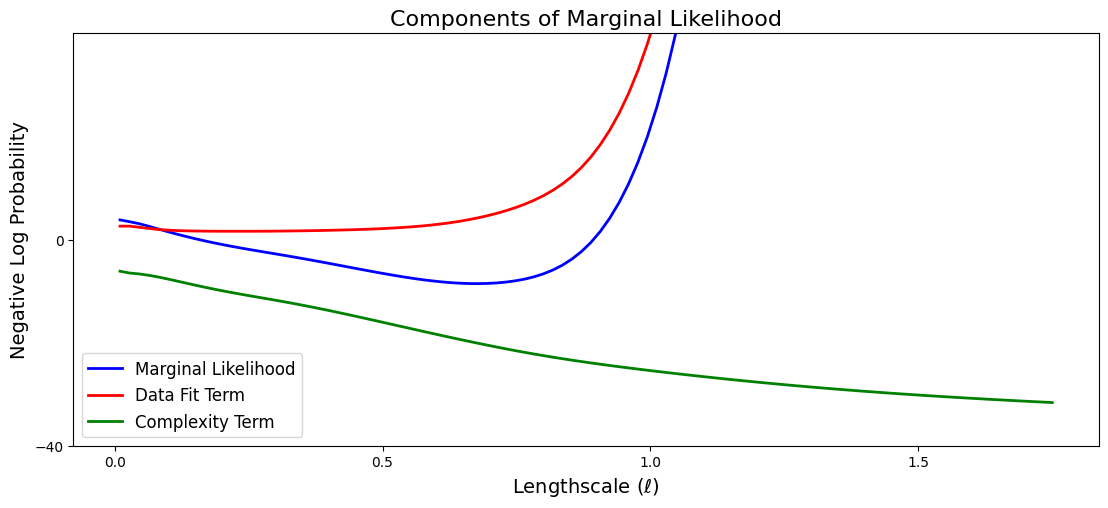

In [ ]:
from gp_functions import neg_log_marginal_likelihood
def decompose_marginal_likelihood(lengthscales):
    neg_log_likelihoods, data_fits, complexities = [], [], []
    params = {'varSigma': 1, 'lengthscale': 1, 'noise': 0.001}  # defining hyperparameters for kernel
    for lengthscale in lengthscales:
        param_keys = list(params.keys())
        current_params = [params['varSigma'], lengthscale, params['noise']]
        neg_log_likelihood, data_fit, complexity, constant_term = neg_log_marginal_likelihood(current_params, param_keys, X, y, zero_mean, rbf_kernel, True)
        neg_log_likelihoods.append(neg_log_likelihood)
        data_fits.append(data_fit)
        complexities.append(complexity)
    return neg_log_likelihoods, data_fits, complexities

lengthscales = np.linspace(0.01, 1.75, 100)
neg_log_likelihoods, data_fits, complexities = decompose_marginal_likelihood(lengthscales)

# Components of log marginal likelihood
fig, ax = plt.subplots(1, 1, figsize=(12,6))
ax.plot(lengthscales, neg_log_likelihoods, label='Marginal Likelihood', color='blue', linewidth=2)
ax.plot(lengthscales, data_fits, label='Data Fit Term', color='red', linewidth=2)
ax.plot(lengthscales, complexities, label='Complexity Term', color='green', linewidth=2)
ax.set_xlabel(r'Lengthscale ($\ell$)', fontsize = 14)
ax.set_ylabel('Negative Log Probability', fontsize = 14)
ax.legend(loc='lower left', fontsize = 12)
ax.set_ylim([-40, 40])
ax.set_xticks([0, 0.5, 1, 1.5])
ax.set_yticks([-40, 0])
ax.set_title('Components of Marginal Likelihood', fontsize = 16)
fig.tight_layout(pad=4.0)
plt.show()


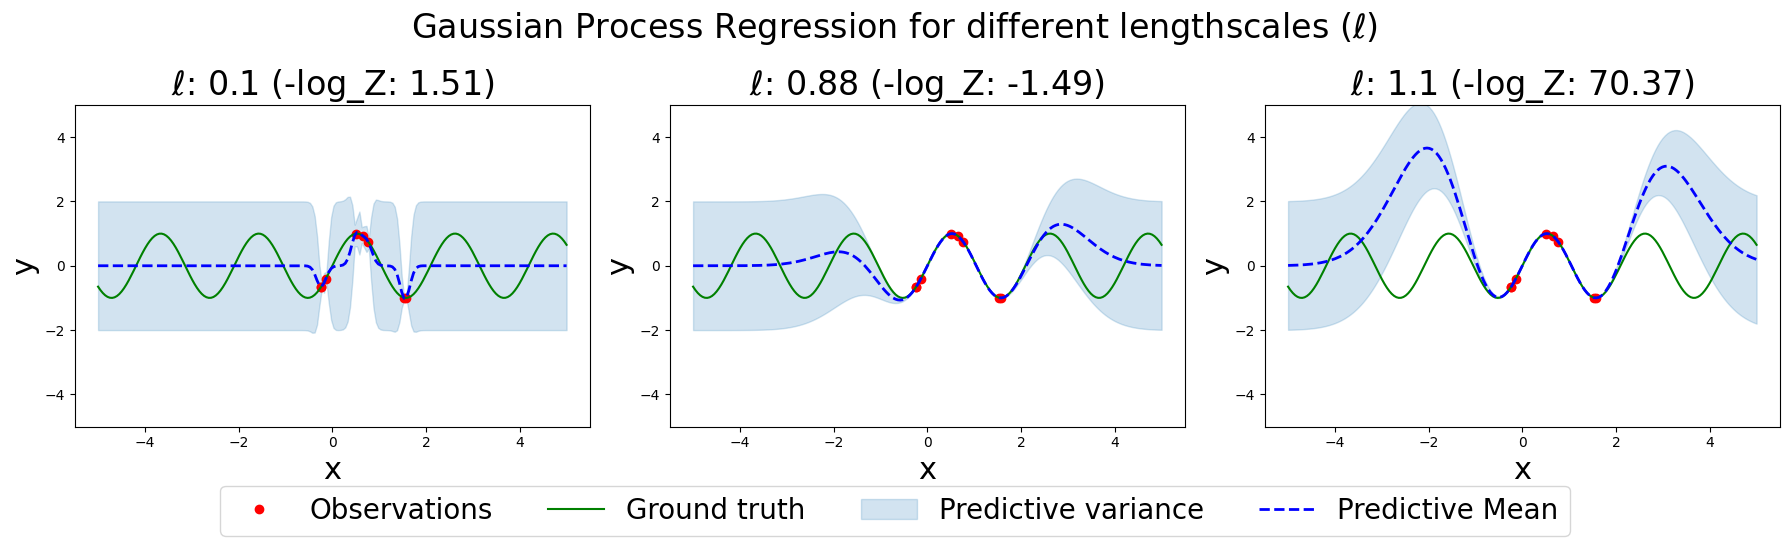

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(18, 5))
lengthscales_to_test = [0.1, 0.88,1.1]
for i, l in enumerate(lengthscales_to_test):
    params["lengthscale"] = l
    mu_f, k_f, log_Z = GP_conditional(zero_mean, rbf_kernel, params, X, y, False)
    m, cov = GP_marginal(mu_f, k_f, Xtest)
    k = np.sqrt(np.diag(cov))
    ax[i].plot(X, y, 'ro', label="Observations")
    ax[i].plot(Xtest, ytest, 'g-', label="Ground truth")
    ax[i].fill_between(Xtest.flatten(), m - 2 * k, m + 2 * k, color='#1f77b4', alpha=0.2, label='Predictive variance')
    ax[i].plot(Xtest, m, 'b--', lw=2, label="Predictive Mean")
    ax[i].set_title(r'$\ell$: {} (-log_Z: {:.2f})'.format(l, log_Z))
    ax[i].set_xlabel('x')
    ax[i].set_ylabel('y')
    ax[i].set_ylim([-5,5])
fig.suptitle(r'Gaussian Process Regression for different lengthscales ($\ell$)', fontsize = 24)


# Consolidate legends
handles, labels = ax[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, -0.1), ncol=4, fontsize = 20)

plt.tight_layout()
plt.show()

What we can see from the previous two plots is that there is a clear trade-off between model complexity and data fit.

- **Data Fit**: Short length scales result in more wiggly functions that better fit the observations. This however increases the complexity penalty.

- **Model Complexity**: Longer length scales reduce model complexity by producing smoother function with less fine-grained details. This however comes at the cost of a worse data fit.

This shows that there is a sweet spot between the data complexity and fit which can be found by hyperparameter optimisation.

### Negative Log marginal likelihood for Hyperparameter optimisation

As previously seen, log marginal likelihood provides a measure of the trade-off between goodness of fit and model complexity. To find the optimal hyperparameters, we maximize the marginal likelihood using its partial derivatives with respect to the hyperparameters, typically through gradient-based methods:

$$
\frac{\partial}{\partial \theta_j} \log p(y \mid X, \theta)
= \frac{1}{2} y^\top K^{-1} \frac{\partial K}{\partial \theta_j} K^{-1} y
- \frac{1}{2} \operatorname{tr} \left( K^{-1} \frac{\partial K}{\partial \theta_j} \right) \\
= \frac{1}{2} y^\top K^{-1} \frac{\partial K}{\partial \theta_j} K^{-1} y \\
- \frac{1}{2} \operatorname{tr} \left( K^{-1} \frac{\partial K}{\partial \theta_j} \right)
$$

where

$$
\alpha = K^{-1} y.
$$

In practice, optimization packages like `autograd` can automatically compute these derivatives and apply gradient-based methods to find the optimal hyperparameters. We provide the `GP_conditional_optimised` which automatically returns the optimized posterior Gaussian Process.

We now plot the 3d contour plots of the negative log marginal likelihood for three different hyperparameters of the RBF kernel.



In [ ]:
from visualisations import compute_log_marginal_likelihood, create_figure
from gp_functions import GP_conditional_optimised
from data import data_1d
# from google.colab import output
# output.enable_custom_widget_manager()

np.random.seed(42)
N = 10
n = 200
noise = 0.5
X2, y2 = data_1d(N, noise)
Xtest = np.linspace(-5, 5, n).reshape(-1, 1)
ytest = f(Xtest)
params_noisy = {'varSigma': 1, 'lengthscale': 1, 'noise': 0.5}
params_copy = params_noisy.copy()
mean_f = zero_mean
kernel_f = rbf_kernel

lengthscales = np.linspace(0.0001, 8, 50) # 8
variances = np.linspace(0.3, 6, 50) #0.001 # 0.3
noises = np.linspace(0.2, 0.8, 50) #0.1

# Perform GP inference to find optimized hyperparameters
print(f"Initial hyperparameters: lengthscale: {params_copy['lengthscale']:.2f}, signal variance: {params_copy['varSigma']:.2f}, noise variance: {params_copy['noise']:.2f}")
mu_f, k_f, log_Z = GP_conditional_optimised(mean_f, kernel_f, X2, y2, params_copy)
print(f"Optimized hyperparameters: lengthscale: {params_copy['lengthscale']:.2f}, signal variance: {params_copy['varSigma']:.2f}, noise variance: {params_copy['noise']:.2f}")

# Compute log marginal likelihood surfaces
Z1 = compute_log_marginal_likelihood(lengthscales, variances, 'lengthscale', 'varSigma', params_copy, X2, y2, zero_mean, rbf_kernel)
Z2 = compute_log_marginal_likelihood(noises, variances, 'noise', 'varSigma', params_copy, X2, y2, zero_mean, rbf_kernel)
Z3 = compute_log_marginal_likelihood(lengthscales, noises, 'lengthscale', 'noise', params_copy, X2, y2, zero_mean, rbf_kernel)

fig1 = create_figure(lengthscales, variances, Z1, 'Lengthscale (λ)', 'Signal Variance (σ_f)',
                     f'Negative Log Marginal Likelihood with Noise Variance(σ_n) = {params_copy["noise"]:.2f}')
fig2 = create_figure(noises, variances, Z2, 'Noise Variance (σ_n)', 'Signal Variance (σ_f)',
                     f'Negative Log Marginal Likelihood with Lengthscale(λ) = {params_copy["lengthscale"]:.2f}')
fig3 = create_figure(lengthscales, noises, Z3, 'Lengthscale (λ)', 'Noise Variance (σ_n)',
                     f'Negative Log Marginal Likelihood with Signal Variance(σ_f) = {params_copy["varSigma"]:.2f}')

# Display the figures in tabs
fig1_widget = go.FigureWidget(fig1)
fig2_widget = go.FigureWidget(fig2)
fig3_widget = go.FigureWidget(fig3)

figures = [fig1,fig2,fig3]
sub_tab = [widgets.Output() for i in range(len(figures))]
tab = widgets.Tab(sub_tab)
for i,k in enumerate([r'λ vs σ_f', 'σ_n vs σ_f', 'λ vs σ_n']):
  tab.set_title(i, k)
  with sub_tab[i]:
    figures[i].show()
display(tab)

Initial hyperparameters: lengthscale: 1.00, signal variance: 1.00, noise variance: 0.50
Optimized hyperparameters: lengthscale: 0.46, signal variance: 1.07, noise variance: 0.35


<div class="alert alert-block alert-info"><b>3D Marginal Likelihood Plot:</b> The 3D plots visualises the log marginal likelihood as a function of two hyperparameters. The third hyperparameter is fixed at the value found during hyperparameter optimization. You can explore the plot by mouse or touch interaction.
</div>

By careful inspection, it can be seen that there are two local optima in the first plot (lengthscale vs. signal variance). Depending on the step size and initial hyperparameter settings, different local optima can be found that produce different data interpretations:
- one local optimum consists of a low lengthscale (0.46) and medium high signal variance (1.07), corresponding to a more complex model with larger variance to explain outliers. This is the global optimum.
- the second local optimum has a higher lengthscale (9.8) but lower the signal variance (0.5), corresponding to a simpler model.


## Model selection

After optimising the hyperparameters, we now have a model that is independent of the hyperparameters. Let's now explicitly specify that we computed the log marginal likelihood after hyperparameter optimization for a model $M_i$. In our example, we choose four different covariance functions as models. The log marginal likelihood for the model is then specified as $p(\textbf{y} \mid \mathbf{X}, M_{i})$

Using Bayes' rule again, we get the posterior probability of the model by specifying a hyperprior $p(M_i)$ which specifies how probable we believe each model is.

$$   
p(M_i | \mathbf{y}, \mathbf{X}) = \frac{p(\mathbf{y} | \mathbf{X}, M_i)p(M_i)}{p(\mathbf{y} | \mathbf{X})}
$$

Since we just assume a uniform hyperprior, this simplifies to selecting the optimized model (after hyperparameter optimization) with the smallest negative log marginal likelihood.

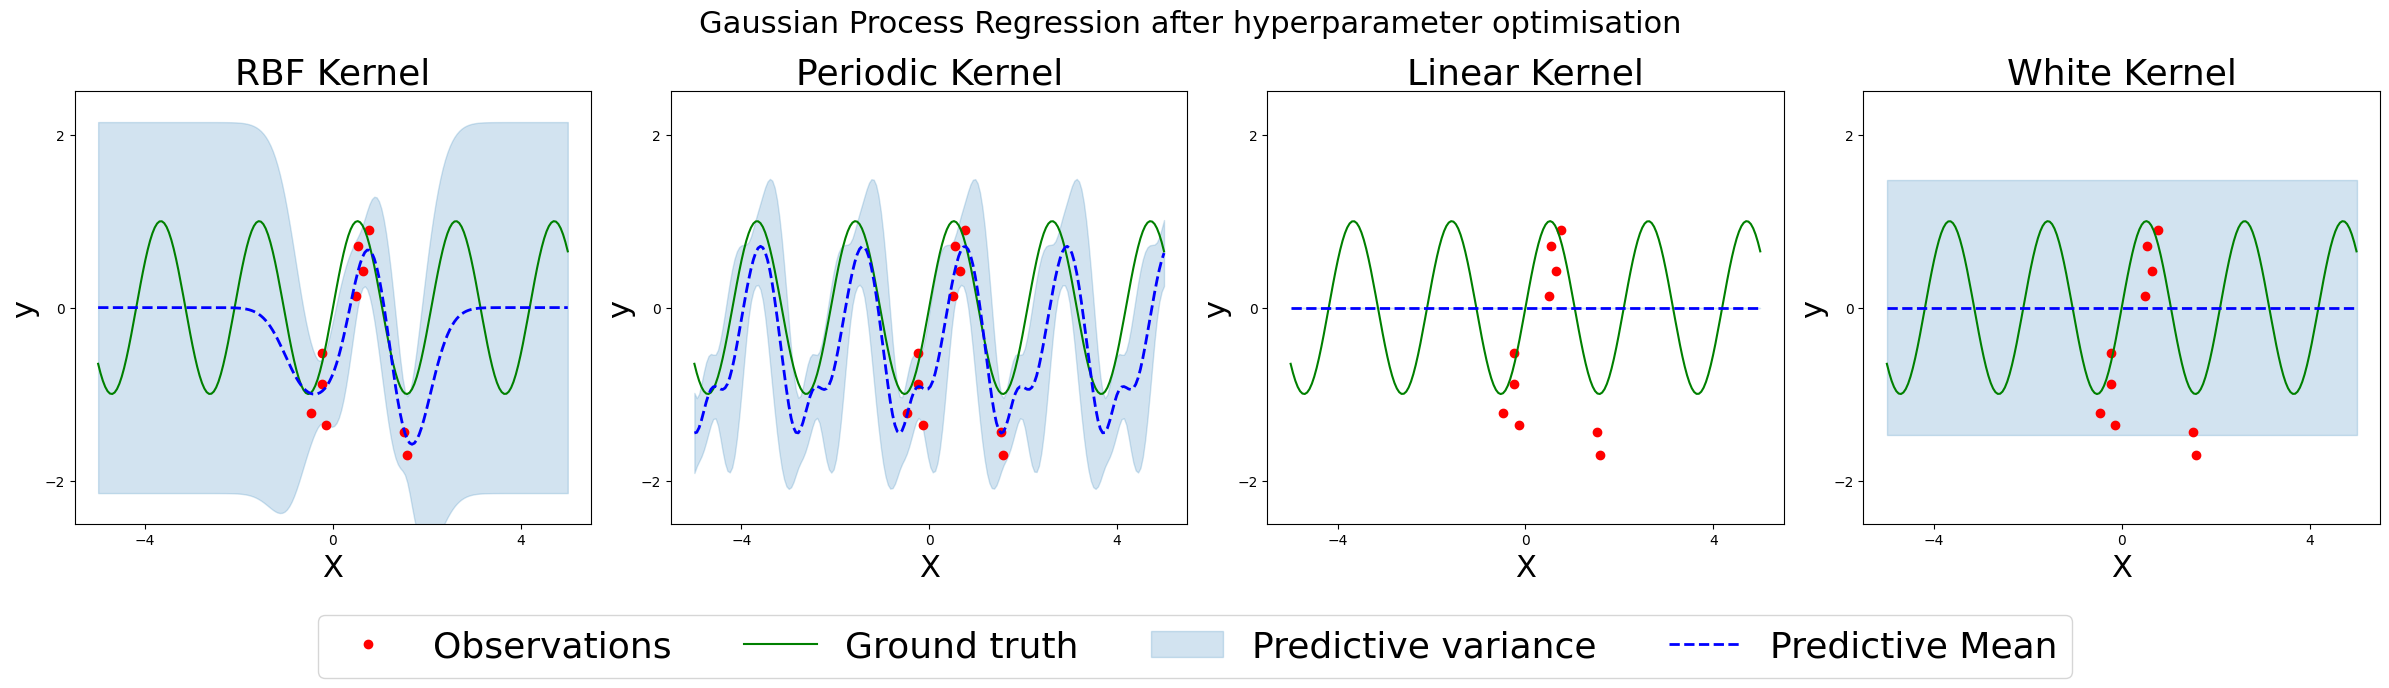

In [ ]:
from visualisations import kernel_comparison_gpr
kernels = [rbf_kernel, periodic_kernel, lin_kernel, white_kernel]
kernel_names = ['RBF', 'Periodic', 'Linear', 'White']
mean_function = zero_mean

#LLs_before, params_before = plot_kernels(X, y, Xtest, kernels, optimised=False, showlegend = False)
LLs_after, params_after = kernel_comparison_gpr(X2, y2, Xtest, ytest, kernels, kernel_names, mean_function, optimised=True, showlegend = True)


In [ ]:
from IPython.display import display, HTML
import pandas as pd

# Initial parameters for comparison (same for all kernels as per the setup)
initial_params_dict = {
    'Kernel': 'Initial Parameters',
    'Lengthscale (ℓ)': 1.00,
    'Signal Variance (σf)': 1.00,
    'Noise Variance (σn)': 1.00,
    'Period (p)': 1.00
}

# Create a DataFrame to display the optimized parameters
opt_params = [initial_params_dict]
for i, kernel in enumerate(kernels):
    param_dict = {
        'Kernel': kernel_names[i],
        'Lengthscale (ℓ)': params_after[i].get('lengthscale', '-'),
        'Signal Variance (σf)': params_after[i]['varSigma'],
        'Noise Variance (σn)': params_after[i]['noise'],
        'Period (p)': params_after[i].get('period', '-')
    }
    opt_params.append(param_dict)


# Create a DataFrame for display
df_opt_params = pd.DataFrame(opt_params)
# Rounding the values to two decimal places and handling '-' replacements
df_opt_params = df_opt_params.map(lambda x: f"{x:.2f}" if isinstance(x, (int, float)) else x)
df_opt_params.loc[(df_opt_params['Kernel'] != 'Periodic') & (df_opt_params['Kernel'] != 'Initial Parameters'), 'Period (p)'] = '-'
df_opt_params.loc[df_opt_params['Kernel'] == 'White', 'Lengthscale (ℓ)'] = '-'

# Reordering columns and removing index
df_opt_params = df_opt_params[['Kernel', 'Lengthscale (ℓ)', 'Signal Variance (σf)', 'Noise Variance (σn)', 'Period (p)']]
display(HTML("<h3>Optimized Hyperparameters for Each Kernel</h3>"))

display(df_opt_params.style.hide())


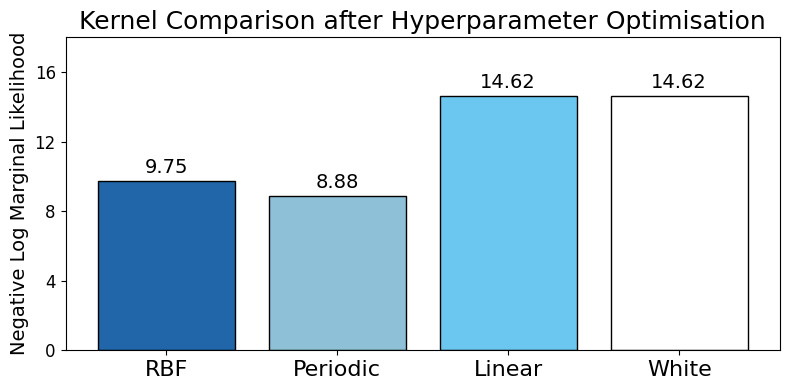

In [ ]:
def barplot_kernel_comparison(kernel_names, LLs, title="Model Comparison"):
    bar_colors = ['#2066a8', '#8ec1d8', '#6bc7f0', '#ffffff']
    fig, ax = plt.subplots(figsize=(8, 4))
    bars = ax.bar(kernel_names, LLs, color=bar_colors, edgecolor="black")

    # Set y-axis label and title with specific font sizes
    ax.set_ylabel('Negative Log Marginal Likelihood', fontsize=14)
    ax.set_title(title, fontsize=18)

    # Set x-axis and y-axis ticks with specific font sizes
    ax.tick_params(axis='x', labelsize=16)  # Font size for x-axis (discrete labels)
    ax.tick_params(axis='y', labelsize=12)  # Font size for y-axis

    # Set y-axis ticks
    ax.set_yticks([0, 4, 8, 12, 16])
    ax.set_ylim([0, 18])

    # Annotate the bars with specific font size
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=14)  # Adjusted fontsize

    plt.tight_layout()
    plt.show()

# Example usage
barplot_kernel_comparison(kernel_names, LLs_after, title="Kernel Comparison after Hyperparameter Optimisation")


In our case, the priodic kernel minimizes the log marginal likelihood after hyperparameter optimization. This is intuitive as our data was generated by (noisy) sinusoidal data and thus, a covariance function modelling periodic behaviour is most suitable for our problem.



```
# Als Code formatiert

```
# Als Code formatiert
```


```

### Main Takeaways:
After completing this tutorial, you should have a solid understanding of Gaussian Processes (GPs) and their applications. The key takeaways are:

- **Model Flexibility**: GPs are highly flexible and can be updated online as new data becomes available. In this case, the posterior GP from previous observations serves as the new prior.
- **Mean Functions**: As often neglected, we discussed the role of the prior mean function for encoding assumptions about the average function behaviour. This becomes particularly important during extrapolation, where the mean function guides the model's predictions in regions with sparse data.
- **Hyperparameter Optimization**: The negative log marginal likelihood incorporates a natural trade-off between model complexity and data fit, making it a powerful tool for automatic hyperparameter optimization.
- **Intuitive Interpretation**: Both the prior and posterior GP are stochastic processes that can be conditioned on new data points or visualised by marginalising over any input space.


### Important Note

Please dont forget to fill out the post-tutorial survey!

(https://docs.google.com/forms/d/e/1FAIpQLScVkvHfAQKjEAZ88Q-HvGx9IDB4K_QZJeeNA4m2eyuzHM0Dyw/viewform?usp=sf_link)


### Further Resources

For a deeper dive into Gaussian Processes, you can consider exploring the following resources:

**Book**  *Gaussian Processes for Machine Learning* by Carl Edward Rasmussen and Christopher K. I. Williams.

**Video Lecture**: [Richard Turner's Lecture on Gaussian Processes](https://www.youtube.com/watch?v=92-98SYOdlY) (November 23, 2016)

**Online Tutorials**:
- [Visual Exploration of Gaussian Processes](https://distill.pub/2019/visual-exploration-gaussian-processes/)
- [Gaussian Process Tutorial by Peter Roelants](https://peterroelants.github.io/posts/gaussian-process-tutorial/)
- [Visualization of Gaussian Processes](http://www.infinitecuriosity.org/vizgp/)
